In [1]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import astropy
from astropy import constants as const
from astropy import units as u
from astropy.cosmology import WMAP9 as cosmo
from astropy.cosmology import LambdaCDM
from scipy import special
import math

In [2]:
#Setting given conditions and constants
peak_abs_mag = -19.5
kappa = 0
omega_r = 0
c = (const.c.to('km/s'))

#Read in data
dataframe = pd.read_csv('SNe_Scattergood.csv')
print(dataframe.head())


   Redshift   AppMag  DAppMag
0    0.2604  21.0399   0.1436
1    0.1636  19.8173   0.0547
2    0.2986  21.2489   0.1899
3    0.1777  19.9634   0.0651
4    0.2170  20.3851   0.0986


In [3]:
#Convert dataframe columns to numpy arrays 
def pd_to_np_array(dataframe, np_name, col):
    """
    Converts an input dataframe column to a numpy array 

    Parameters:
    - dataframe: Series, pandas dataframe to read data from
    - np_name: Name of returned numpy array 
    - col: Str, Name of dataframe column to convert

    Returns:
    - numpy array of column data 
    """
    np_name = dataframe[col].to_numpy()
    return np_name

In [4]:
#Use above function to create numpy arrays of each column 
Z = pd_to_np_array(dataframe, "Z", "Redshift")
app_mag = pd_to_np_array(dataframe, "app_mag","AppMag")
app_mag_error = pd_to_np_array(dataframe, "app_mag_error","DAppMag")

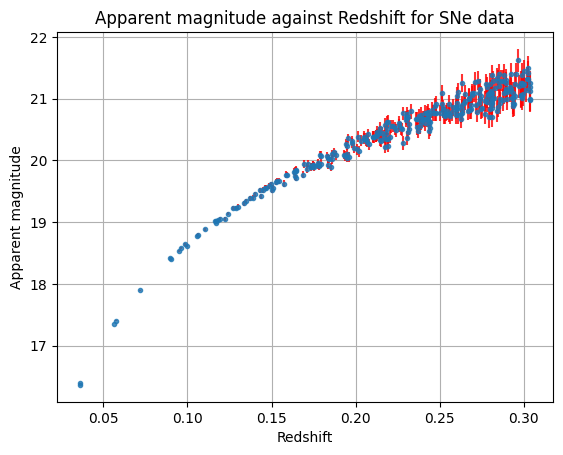

In [5]:
fig, axis = plt.subplots()

#plot Redshift against Apparent magnitude with error bars
plt.errorbar(Z, app_mag, yerr=app_mag_error, fmt='.', ecolor='r', alpha=0.8)

#Figure labelling
plt.ylabel('Apparent magnitude')
plt.xlabel('Redshift')
plt.title('Apparent magnitude against Redshift for SNe data')
plt.grid()

plt.show()

The relation between luminosity distance, $d_L$, apparent magnitude, m,  and absolute magnitude, M, is given by:

$$
M = m − 5log10(d_L) + 5
$$

Which can be rearranged for $d_L$:

$$
 d_L= 10^{\frac{m-M+5}{5}}
$$

In [6]:
#def luminosity_distance():
 #   '''
#
 #   '''
  #  lum_dis_pc = (10**((m - peak_abs_mag + 5)/5))* u.pc

In [7]:
# Retrieve apparent magnitude value correspnding to lowest Redshift value 
m = dataframe.loc[dataframe['Redshift'].idxmin()]['AppMag']

#Calculate luminosity distance in units of Mpc
lum_dis_Z_min = (10**((m - peak_abs_mag + 5)/5))/1000000 * u.Mpc

#lum_dis = lum_dis_pc.to(u.Mpc)
print(lum_dis_Z_min)

148.92924916778634 Mpc


Convert luminosity distance to proper distance using:
$$
d_p = \frac{d_L}{(1+Z)}
$$

Hubble constant can be calculated using the following equation:
$$
H_0 = \frac{c z}{d_p}
$$

In [8]:
print(f"Lowest redshift value in dataframe: {Z.min()}")

# calculate proper distance using above equation, lowest redshift value and luminosity distance calculated in above cell 
proper_dis = lum_dis_Z_min/(1+Z.min())
print(f'Proper distance is {proper_dis}')
print(f'Luminosity distance is {lum_dis_Z_min}')

H_0 = (c*Z.min())/proper_dis

print(f"H_0 is {H_0}") 

Lowest redshift value in dataframe: 0.0359
Proper distance is 143.76797873133154 Mpc
Luminosity distance is 148.92924916778634 Mpc
H_0 is 74.86054500573225 km / (Mpc s)


In [9]:
#Calculate luminosity distance (in pc) for all SNe in dataset by passing in app_mag numpy array from 4th cell
lum_dis_all_pc = (10**((app_mag - peak_abs_mag + 5)/5)* u.pc)

# convert to Mpc
lum_dis_all_mpc = lum_dis_all_pc.to(u.Mpc)

#append values to dataframe
dataframe['Lum_dis[Mpc]'] = lum_dis_all_mpc.value.tolist()
print(dataframe)

     Redshift   AppMag  DAppMag  Lum_dis[Mpc]
0      0.2604  21.0399   0.1436   1282.271531
1      0.1636  19.8173   0.0547    730.230553
2      0.2986  21.2489   0.1899   1411.822178
3      0.1777  19.9634   0.0651    781.052092
4      0.2170  20.3851   0.0986    948.462141
..        ...      ...      ...           ...
295    0.2182  20.3484   0.0997    932.566907
296    0.2412  20.7697   0.1227   1132.243927
297    0.1976  20.2841   0.0812    905.357284
298    0.0986  18.6368   0.0191    423.994282
299    0.2123  20.3890   0.0942    950.167125

[300 rows x 4 columns]
<class 'numpy.ndarray'>
[1282.27153051  730.23055306 1411.82217849  781.05209206  948.46214059]


In [16]:
# Set cosmological conditions for omega matter, omega dark energy and hubble constant 
conditions = LambdaCDM(H0=H_0, Om0=0.5, Ode0=0.5)

# Calculate luminosity conditions for given conditions and redshift
dl = conditions.luminosity_distance(Z.max())
print(f'Luminosity distance with H_0={H_0} and when both omega matter and omega dark energy are 0.5 is: {dl}')

Luminosity distance with H_0=74.86054500573225 km / (Mpc s) and when both omega matter and omega dark energy are 0.5 is: 1413.9116644729684 Mpc


In [56]:
# Create an array from 0.01 to Z_max in increments of 10^-3
Z_array = np.arange(0.01, Z.max() + 0.001, 10**-3)
#print(len(Z_array))

# Use luminosity distance function of cosmology package on Z_array
lum_dis_array = np.array(conditions.luminosity_distance(Z_Array)) # in Mpc

Given that:
$$
M = m -5 log_{10}(d_L) + 5
$$

Rearranging for apparent magnitude:
$$
m = 5log_{10}(d_L) - 5 -M
$$

In [57]:
#apparent_magnitude_array = 5*np.log10(lum_dis_array) - 5 - peak_abs_mag
#apparent_magnitude_array = -peak_abs_mag + 5*np.log10(lum_dis_array) - 5
apparent_magnitude_array = 5*np.log10(lum_dis_array) - 5 - peak_abs_mag

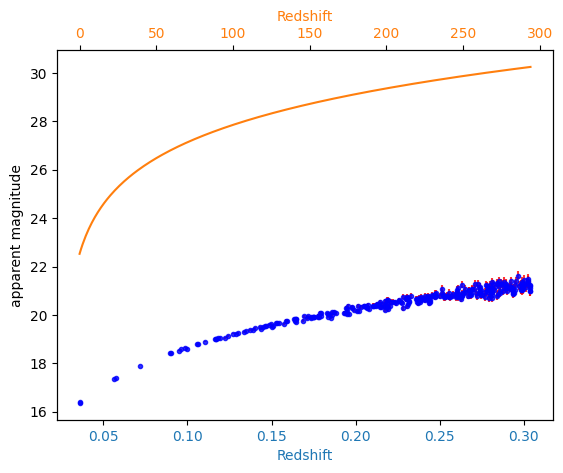

In [78]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Redshift', color=color)
ax1.set_ylabel("apparent magnitude")
ax1.tick_params(axis='x', labelcolor=color)

ax1.errorbar(Z, app_mag, yerr=app_mag_error, color="blue", fmt='.', ecolor='r', alpha=0.8, label="SNe data")#

ax2 = ax1.twiny()
color2 = 'tab:orange'
ax2.set_xlabel("Redshift", color=color2)
ax2.tick_params(axis='x', labelcolor=color2)

ax2.plot(apparent_magnitude_array, label="cosmological calculation", color=color2)


plt.show()

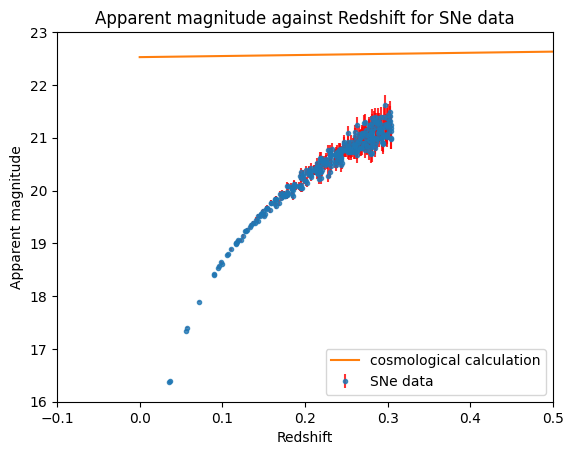

In [62]:
plt.errorbar(Z, app_mag, yerr=app_mag_error, fmt='.', ecolor='r', alpha=0.8, label="SNe data")
plt.plot(apparent_magnitude_array, label="cosmological calculation")
#plt.errorbar(Z, apparent_magnitude_array, yerror=app_mag_error, fmt=".", ecolor="b", alpha=0.8, label="cosmological calculation")

plt.ylabel('Apparent magnitude')
plt.xlabel('Redshift')
plt.title('Apparent magnitude against Redshift for SNe data')

plt.legend()
plt.ylim(16, 23)
plt.xlim(-0.1, 0.5)
plt.show()

In [33]:
def apparent_magnitude(H0, omega_m, omega_de):
    """
    A function that takes cosmological parameters, calculates luminosity distance and returns a numpy array of apparent magnitude values

    Parameters:
     - H0: float, Hubble's constant
     - omega_m: float, matter density of the unvierse 
     - omega_de: float,  dark enegy density of the universe

     Returns
     - apparent_magnitude_array, a numpy array 
    """

    cosmology = LambdaCDM(H0=H0, Om0=omega_m, Ode0=omega_de)
    luminosity_distance_array = np.array(cosmology.luminosity_distance(Z_Array))
    apparent_magnitude_array = 5*np.log10(luminosity_distance_array) - 5 - peak_abs_mag

    return apparent_magnitude_array

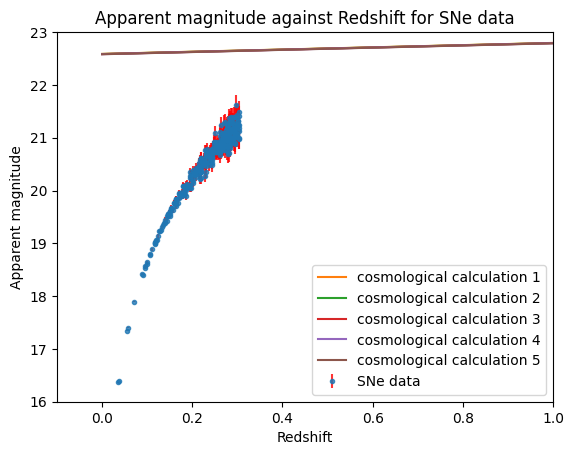

In [37]:
app_mag_1 = apparent_magnitude(73, 0.1, 0.9)
app_mag_2 = apparent_magnitude(73, 0.2, 0.8)
app_mag_3 = apparent_magnitude(73, 0.3, 0.7)
app_mag_4 = apparent_magnitude(73, 0.4, 0.6)
app_mag_5 = apparent_magnitude(73, 0.5, 0.5)




plt.errorbar(Z, app_mag, yerr=app_mag_error, fmt='.', ecolor='r', alpha=0.8, label="SNe data")
plt.plot(app_mag_1, label="cosmological calculation 1")
plt.plot(app_mag_2, label="cosmological calculation 2")
plt.plot(app_mag_3, label="cosmological calculation 3")
plt.plot(app_mag_4, label="cosmological calculation 4")
plt.plot(app_mag_5, label="cosmological calculation 5")


plt.ylabel('Apparent magnitude')
plt.xlabel('Redshift')
plt.title('Apparent magnitude against Redshift for SNe data')

plt.legend()
plt.ylim(16, 23)
plt.xlim(-0.1, 1)
plt.show()